# Performance comparison of Sudoku solvers

Here I compare the performance of three Sudoku solving programs on the same data:

 * one written in **C** (the fast one)
 * one written in **Julia** (that funky new language)
 * Peter Norvig's **Python** Sudoku solver, both in CPython and PyPy.
 
These all use essentially the same algorithm with some minor (?) implementation differences. I wrote the C and Julia versions with guidance from [Peter Norvig's blog post](http://norvig.com/sudoku.html), albeit, one could say, a bit less elegantly.

In [1]:
sudoku_fn = 'top95.txt'
common_args = ['-s', '--timeit=10']

commands = {
    'CPython 3.5': ['python3.5', 'sudoku.py'] + common_args,
    'PyPy3 5.9': ['pypy3', 'sudoku.py'] + common_args,
    'C': ['./sudoku', '-C'] + common_args,
    'Julia': ['julia', 'sudoku.jl', '-C'] + common_args
}

gen_command = ['./gen-sudoku', '-s', '1000']

In [2]:
%matplotlib inline
import time
import subprocess
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%%bash
make

make: Nothing to be done for 'all'.


Our test data consists of 1000 randomly generated sudokus (by the code in `generator.c`) –

In [4]:
print('Generating 1000 sudokus...')
t0 = time.perf_counter()
random_sudokus = subprocess.run(gen_command, stdin=subprocess.DEVNULL,
                                             stdout=subprocess.PIPE,
                                             stderr=subprocess.DEVNULL).stdout
print('Done in', time.perf_counter() - t0, 'seconds')

Generating 1000 sudokus...
Done in 116.15993517398601 seconds


These sudokus:
 * Are based on a randomly generated solution by randomly removing clues
 * Are guaranteed to have a unique solution
 * Will no longer be unique if any clue is removed
 
My hope is that this will make them “hard-ish”. The number of clues left varies, and with it the difficulty. It's a nice mix.

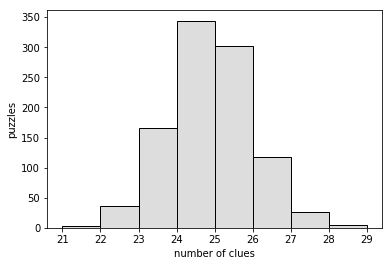

In [5]:
n_nums = [len([c for c in l if c != '.'])
          for l in random_sudokus.decode().strip().split('\n')]

plt.hist(n_nums, bins=8, color='#dddddd', edgecolor='k')
plt.xlabel('number of clues')
plt.ylabel('puzzles')

The programs are going through the list of sudokus once, and solving each one ten times in a row (to increase the reliability of the benchmark).

In [6]:
outputs = {}
run_times = {}

for impl, cmd in commands.items():
    print("Solving test puzzles:", impl)
    t0 = time.perf_counter()
    proc = subprocess.run(cmd, input=random_sudokus,
                               stdout=subprocess.PIPE)
#     proc = subprocess.run(cmd + ['top95.txt'], stdin=subprocess.DEVNULL,
#                           stdout=subprocess.PIPE)
    dt = time.perf_counter() - t0
    run_times[impl] = dt
    print("... done in {:.2f} s".format(dt))
    outputs[impl] = proc.stdout.decode('ascii')
    

Solving test puzzles: C
... done in 1.28 s
Solving test puzzles: PyPy3 5.9
... done in 36.81 s
Solving test puzzles: Julia
... done in 14.88 s
Solving test puzzles: CPython 3.5
... done in 71.53 s


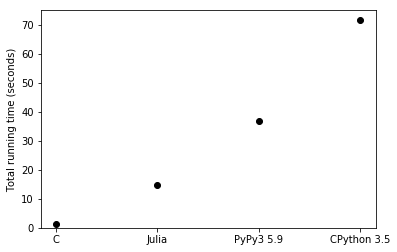

In [7]:
run_time_sorted = pd.Series(run_times).sort_values()

plt.plot(run_time_sorted.values, 'ko')
plt.xticks(range(len(run_time_sorted)), run_time_sorted.index)
plt.ylabel('Total running time (seconds)')
plt.ylim(0, 5 * np.ceil(run_time_sorted.max()/5))
None

To the surprise of absolutely noone, the C implementation is by far the fastest. Julia appears to be, to the shock of anybody who has seen the benchmarks on [julialang.org](https://julialang.org), much slower than C.

Norvig's Python code is, of course, much slower than my C version, but reassuringly PyPy's tracing JIT does an excellent job for this kind of repetitive calculation.

In [8]:
df = pd.DataFrame()
for impl, output in outputs.items():
    df[impl] = [float(l.strip().split()[1]) for l in output.strip().split('\n')]

If we look at the performance on a puzzle-by-puzzle basis, a somewhat different picture emerges:

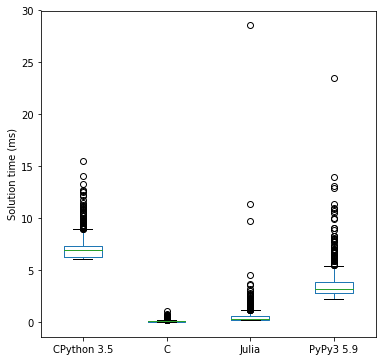

In [9]:
df.plot.box(figsize=(6,6))

plt.ylabel('Solution time (ms)')

Naturally some puzzles are much harder than others and take all the programs a bit more time. The really striking thing is, though, that the Julia and C implementations are *much* closer together than before!

Anybody who has actually used Julia will know that this largely due to Julia's agonising JIT overhead: before getting to any actual calculations, the Julia program has to do things like compile the [ArgParse](https://github.com/carlobaldassi/ArgParse.jl) module, not to mention some of my code. The compilation overhead of the actual Sudoku solving methods, however, do show up in the running time for the first puzzle:

In [10]:
df[['Julia','PyPy3 5.9']].head()

,Julia,PyPy3 5.9
0,28.559399,23.486108
1,11.433506,10.747559
2,0.244784,10.018841
3,0.278592,5.612621
4,0.537586,7.953569


PyPy, which also uses a JIT, shows the same behaviour, but it's much less pronounced. In part this may be due to the fact that PyPy has a *tracing* JIT, but mostly it's due to its JIT being much faster and producing a much more modest performance gain.

Now, if we hide the outliers in the above plot, we can finally actually see what's going on.

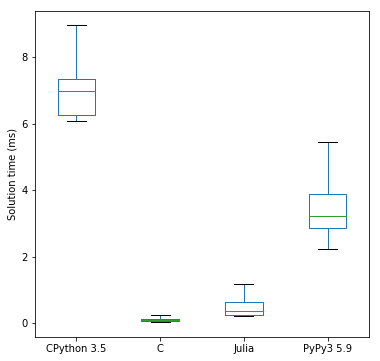

In [11]:
df.plot.box(showfliers=False, figsize=(6,6))
plt.ylabel('Solution time (ms)')

On average, the Julia code is some 4.6 times slower than the C version, while the Python code closer to 30–60 times slower.

In [12]:
df.mean()

CPython 3.5    7.121367
C              0.125761
Julia          0.585234
PyPy3 5.9      3.624172
dtype: float64

In [13]:
df.mean() / df['C'].mean()

CPython 3.5    56.625968
C               1.000000
Julia           4.653526
PyPy3 5.9      28.817818
dtype: float64

In [14]:
df.std() / df.mean()

CPython 3.5    0.148604
C              0.847317
Julia          1.869212
PyPy3 5.9      0.402558
dtype: float64